## Importance Weighted Autoencoder

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
z_dim = 50
batch_size = 100
nb_steps = 100000
k = 5

In [3]:
def render_images(np_x):
    np_x = np_x.reshape((10,10,28,28))
    np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
    np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
    x_img = np.squeeze(np_x)
    plt.imshow(x_img, cmap='Greys_r')
    plt.title('Generation')
    plt.show()

In [4]:
def encoder(x, z_dim=20, reuse=False):
    with tf.variable_scope("encoder", reuse=reuse):
        l1 = tf.layers.dense(x, 200, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, 200, activation=tf.nn.relu)
        mu = tf.layers.dense(l2, z_dim, activation=None)
        sigma = 1e-6 + tf.nn.softplus(tf.layers.dense(l2, z_dim, activation=None))
        return mu, sigma

In [5]:
def decoder(z, z_dim=20, reuse=False):
    with tf.variable_scope("decoder", reuse=reuse):
        l1 = tf.layers.dense(z, 200, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, 200, activation=tf.nn.relu)
        x_hat = tf.layers.dense(l2, 784, activation=tf.nn.sigmoid)
        return x_hat

In [6]:
def objective(z, mu, sigma, x, x_hat, training=True):
    log2pi = tf.log(2 * np.pi)
    log_QzGx = (-(z_dim / 2)*log2pi 
                + tf.reduce_sum(- tf.log(sigma) - 0.5 * tf.squared_difference(z, mu) / (2 * tf.square(sigma)), -1))
    log_PxGz = tf.reduce_mean(tf.reduce_sum(x * tf.log(x_hat + 1e-8) + (1 - x) * tf.log(1 - x_hat + 1e-8), [1]))
    log_Pz = (-(z_dim / 2)*log2pi 
                + tf.reduce_sum(- 0.5 * tf.squared_difference(z, 0) / 2, -1))
    if training:
        log_weights = tf.reshape(log_PxGz + log_Pz - log_QzGx, [k, batch_size])
        weights = tf.exp(log_weights - tf.reduce_max(log_weights, 0))
        normalized_weights = weights / tf.reduce_sum(weights, 0)
        loss = -tf.reduce_mean(tf.reduce_sum(normalized_weights * log_weights, 0))
    else:
        log_weights = tf.reshape(log_PxGz + log_Pz - log_QzGx, [5000, 1])
        log_wmax = tf.reduce_max(log_weights, 0)
        weights = tf.exp(log_weights - log_wmax)
        loss = -tf.reduce_mean(tf.log(tf.reduce_mean(weights, 0))) -tf.reduce_mean(log_wmax)
    return loss

In [7]:
x = tf.placeholder(tf.float32, [batch_size, 784])
x_k = tf.tile(x, [k, 1])
mu, sigma = encoder(x_k, z_dim=z_dim)
z = mu + sigma * tf.random_normal([k * batch_size, z_dim], 0, 1, dtype=tf.float32)
x_hat = decoder(z)

In [8]:
loss = objective(z, mu, sigma, x_k, x_hat)

In [9]:
x_test = tf.placeholder(tf.float32, [1, 784])
x_k_test = tf.tile(x_test, [5000, 1])
mu_test, sigma_test = encoder(x_k_test, z_dim=z_dim, reuse=True)
z_test = mu_test + mu_test * tf.random_normal([5000 * 1, z_dim], 0, 1, dtype=tf.float32)
x_hat_test = decoder(z_test, reuse=True)

In [10]:
test_loss = objective(z_test, mu_test, sigma_test, x_k_test, x_hat_test, False)

In [11]:
optim_op = tf.train.AdamOptimizer(1e-4).minimize(loss)
init_op = tf.global_variables_initializer()

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Step: 5000 in 24.85s :: Loss: 122.560


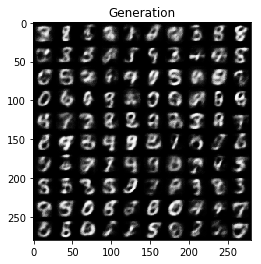

In [14]:
sess.run(init_op)
start_time = time.time()
for stp in range(1, 6000+1):
    x_np, _ = mnist.train.next_batch(batch_size)
    _, loss_np = sess.run([optim_op, loss], feed_dict={x: x_np})
    if stp % 5000 == 0:
        end_time = time.time()
        print('Step: {:d} in {:.2f}s :: Loss: {:.3f}'.format(stp, end_time - start_time, loss_np))
        start_time = end_time
        x_hat_np = sess.run(x_hat, feed_dict={z: np.random.randn(500, z_dim)})
        render_images(x_hat_np[:100])

In [15]:
x_np.shape

(100, 784)

In [16]:
running_test_loss = 0.
for i, img in enumerate(mnist.test.images):
    x_np = img[None, :]
    loss_np = sess.run(test_loss, feed_dict={x_test: x_np})
    print(loss_np)
    running_test_loss += loss_np
    if i % 1000 == 0:
        print(i)

-2.2750893
0
-74.12996
17.569454
-140.44978
56.239185
2.6939673
-3.4168282
111.642525
48.703083
-19.093037
51.899635
115.59069
-25.422615
-114.13307
-0.8747463
77.148865
1.8417473
-28.105488
-129.02412
24.97723
3.4889755
17.571974
80.62082
72.41855
5.0636826
43.445873
32.107475
32.755543
-240.40858
18.455334
44.262016
16.830843
-97.752396
113.869225
22.317944
109.099144
-26.140522
1.1407738
101.90574
-15.236012
-18.267673
55.75815
-277.55502
53.1799
21.897839
-2.5043983
48.32134
-34.00862
-335.22705
28.666859
-14.792539
-64.6317
109.02046
11.548183
158.30714
-21.75064
-24.045399
12.658142
-58.991596
6.082531
16.76384
57.35693
12.4220705
-43.368828
90.213005
28.964
116.90985
21.941982
-121.38841
53.82321
-60.31798
-31.636036
81.10883
-25.877655
8.953059
-16.548176
1.5612798
41.27519
80.50505
18.076794
-31.548603
80.75304
-5.0602913
31.154972
61.79174
-199.1156
-32.784122
50.649517
73.16586
36.314693
-13.53014
68.43104
-50.70693
-44.200855
-100.43086
-71.87275
45.892822
35.643032
15.3283

91.537796
15.363971
4.025158
10.538876
43.560608
33.409122
-34.595238
-755.22656
-68.85741
-14.190393
78.24564
64.68979
-126.18773
28.331713
14.761837
-192.93849
105.59416
136.07599
68.01375
-29.540268
-8.062901
-83.566696
-77.48192
9.757076
-73.32753
65.48427
-44.774372
67.2265
15.655526
74.942276
-7.1012344
-15.324085
36.552486
3.4369822
-52.42336
99.541275
-202.68071
77.40114
44.404556
94.518845
30.475826
20.623821
28.334461
53.55868
-55.009907
108.78209
0.6930046
10.9272995
16.749493
41.039032
58.414288
-56.079304
54.909557
9.570598
-10.522234
29.126324
57.766598
-18.492496
-194.72255
-133.66936
-474.62955
16.678616
18.954985
17.023912
27.995537
71.05683
-101.61043
-47.243748
-89.14967
43.623848
80.716064
-19.841877
39.5693
69.03822
-28.743969
-82.41826
33.35981
19.731653
-149.29384
-65.19963
20.091724
40.57803
72.04863
67.91723
-194.3908
12.448711
89.77949
-50.576405
104.46925
-42.853973
13.083874
36.509075
13.203066
20.392555
-3.8441963
-83.25972
39.643425
5.2365246
99.90461
2.05

49.63935
51.109142
93.83998
-22.45832
60.382416
-67.85463
-214.33455
17.991753
-0.32295895
164.40053
34.34332
7.371929
-19.113338
6.930502
-22.186832
-14.19849
11.910104
82.87393
13.611613
-94.11565
-99.29204
-0.40532303
90.75591
61.973644
-4.696325
-222.27278
-177.2187
-40.939533
-80.161026
40.439148
-26.168844
-15.418232
2.63966
-11.642158
60.494186
-31.140553
-15.480179
8.840841
32.31648
-25.956287
78.99577
46.472126
-45.643772
-1.320302
-46.395008
7.0449667
-49.18438
-54.75948
13.011546
84.522705
100.353294
-18.37447
-71.54945
41.489456
-142.74388
-66.92525
13.407785
4.6724815
-50.806202
-15.812229
48.167038
-13.237746
-20.331612
8.527493
-38.234467
40.072258
-117.64244
-155.58995
-39.97533
78.27722
21.015938
17.447187
60.934704
88.02719
-29.950552
-17.381916
6.956341
33.89172
-26.073795
75.0065
-276.66513
78.92271
102.22856
106.36195
71.82378
28.636028
140.66434
10.830517
-13.329374
-13.711414
-128.57643
-82.785736
10.330624
2.5516167
6.367217
-108.97957
-45.40923
-227.02406
0.280

-383.8029
-258.38638
-31.615177
-69.32169
-20.062946
-135.13564
67.80051
-4.136958
55.433865
34.090767
34.263462
40.717373
21.510345
70.186455
28.27406
127.48516
78.23829
62.90728
76.98076
23.876049
-21.370518
-10.248005
-216.88068
-50.321217
74.54803
47.030754
26.940434
-95.87962
-40.39867
10.570049
-25.95914
-7.6321716
-79.2491
-66.32712
2.3280277
-151.1794
44.374416
25.549126
-224.6121
25.213238
-17.488087
-5.8684273
-57.164448
58.343346
83.65106
40.478477
73.82708
77.279076
117.00333
132.28838
31.448399
0.5394392
26.009949
40.049572
-86.211
-13.075962
107.81463
-146.72728
68.96686
26.82824
-48.190815
-1.9614754
-10.5103245
-8.968059
82.57461
-146.48714
-28.987415
31.14021
60.596325
20.98735
-7.971428
-707.58203
59.085136
50.113964
82.622345
103.455315
146.4095
5.4570885
-132.59114
23.145119
49.333935
-29.514246
-7.521839
-180.88988
23.440699
-6.445443
-71.3781
56.38135
72.01303
-51.063587
-12.535923
-30.312151
89.973724
-155.37163
-234.90297
54.48422
9.546843
19.154934
-13.843098
3

-50.241077
56.662807
3.4907188
76.95755
71.05298
-108.80805
19.660633
-50.27251
4.374279
61.04177
-27.242191
43.692326
-127.09355
-120.92053
86.8097
9.382256
-171.42436
24.765636
-13.366962
-17.204548
-75.353775
-33.412754
-5.8707924
92.47623
105.098785
-8.200657
23.241718
17.064371
-120.49309
-5.970725
-14.989573
76.21043
53.16111
39.172527
21.419537
-136.60674
16.242825
-205.85988
-13.5411415
52.561695
29.558949
30.944715
-169.87502
63.27778
77.854195
-50.435246
82.1364
-90.78697
18.690748
25.927917
-79.05299
60.789825
-29.172611
56.132576
41.61627
18.642673
-382.87622
-15.33559
-89.116135
-35.901295
-49.20595
-265.22986
26.871914
24.684711
10.260831
-31.776402
-7.177601
9.884792
57.22807
45.740444
-43.73964
-121.0186
20.14262
-213.75627
115.83675
-15.643055
-27.114147
39.756695
46.970013
51.31215
14.131359
15.621919
106.61365
61.24807
-180.02876
32.076687
-62.028034
22.21096
-24.859653
-5.277424
49.46513
55.955902
24.978357
-24.012379
98.84065
9.708862
-45.92743
16.719383
-269.0729


63.032127
48.450073
-8.801934
17.90762
43.892635
22.59876
-84.52074
34.411995
85.24357
-117.00755
40.59252
-74.527695
26.81563
79.735825
-23.206562
55.58184
62.84779
17.873516
-47.961964
-38.499798
23.35551
-111.30936
23.497631
98.49314
83.978226
52.81364
-71.11376
18.791409
4.529685
95.97928
-169.76799
-12.797107
4.220913
83.39773
-67.66589
-22.783981
79.22179
9.610088
2.8385897
-114.517654
-27.498615
-32.47591
-68.26128
-0.17331314
48.499886
-99.082184
-4.7190685
-27.971638
65.53488
105.96221
-105.57713
11.261456
39.17384
49.86612
-7.8297453
-170.44292
46.208942
62.578022
4.8511305
26.550423
82.03905
21.595749
32.725906
-44.883118
-55.177696
36.545555
-145.7848
113.78055
139.22495
19.612865
67.96216
18.373615
83.579834
-41.646717
-78.31703
37.896214
-260.07544
11.472145
57.719204
-175.14067
-45.787296
70.46517
87.513435
-184.50432
-10.623951
-209.4096
63.675423
62.196945
162.30103
-5.27248
23.922527
20.81596
60.581955
90.016945
-80.07701
33.909374
26.445036
-336.14218
122.0503
14.296

53.782207
-127.36952
31.642435
55.499645
62.430428
-76.9713
-128.97649
68.42834
22.39378
135.31822
-0.7796459
-23.980078
-86.04302
26.728743
-64.726585
-0.061089516
-228.59822
10.571148
78.4222
68.70295
-59.90079
26.402847
58.097576
101.14397
48.404736
19.297771
106.45948
12.207867
54.957703
-591.8142
15.798546
-100.03908
-232.45378
-327.16412
-123.64946
17.666218
-110.78142
2.648693
-177.02696
-182.36421
22.788002
-42.41338
-453.20645
-37.039753
-39.42813
1.1026268
-106.45671
-15.492359
-188.5785
-61.349842
17.167511
-128.04723
-68.14693
-134.55403
-77.40289
25.456062
-124.27263
5.89027
-131.41899
38.119057
-132.75075
-116.61033
28.45303
21.845268
-320.93536
-12.2069435
-315.15686
-127.49559
-32.005604
-38.98605
6.991109
-98.03455
-13.1782055
16.998182
-90.681656
24.924858
-18.233692
17.703587
-10.044562
-683.785
-357.76425
10.89806
-16.611515
-2.0542364
-70.85747
-90.88548
-3.8003435
-153.13423
34.361694
-16.015781
-15.00275
-4.17342
-98.230515
-6.081835
-125.03722
51.174503
-132.848

-348.24014
-194.36653
-181.98456
-279.26724
-221.68367
-23.18404
-143.38231
-133.6809
-221.19081
-5.329273
-266.81055
-383.11252
-353.2127
-58.78469
45.819965
-83.789536
-13.454426
-98.06767
-22.81609
-18.801151
-89.73811
-112.35097
-195.85725
66.50112
65.99346
-16.375172
-171.54518
-97.38478
-18.976643
-81.01631
37.548107
73.18952
-167.0879
-404.24298
-216.74913
-521.76697
-186.50352
2.3480034
-37.645683
-365.90872
27.35075
-115.35506
-197.6566
-99.46715
-22.994312
67.87983
18.963974
-91.1674
-57.09261
30.049053
-151.2488
-3.1139832
14.462552
-301.50723
-8.22859
-93.1512
101.92691
-48.452106
57.70924
-70.90086
-84.501175
-12.77837
-94.45317
-407.58072
-15.814808
-352.78903
-6.768425
-26.847218
-125.58513
-197.12675
7.5083733
3.6339798
50.043438
-90.56886
-46.877846
80.015976
-437.39664
-26.765461
64.85248
-164.47243
-15.924635
2.0476322
-321.96893
-107.19894
76.52301
-207.98863
-125.01311
-299.49176
-185.04663
-114.77733
-66.47392
-153.86937
-166.9171
-17.828651
-105.525955
-2.4049606

10.894268
17.552563
-12.65031
65.88814
-13.490019
76.68906
-97.89102
-51.016613
5.642742
-65.77054
-1.1411476
32.42996
87.5615
12.314556
-52.899727
43.05345
-133.60417
-196.53154
27.295021
52.979626
15.851366
17.740486
-66.06402
79.48651
29.886003
32.118633
-25.138985
17.940746
-88.89378
-61.01303
-11.757923
60.491474
1.5419893
26.679836
10.232962
-155.68301
20.057888
-5.2041664
53.184322
-88.778
25.050915
24.565384
29.221294
15.633893
3.5806236
-8.831837
-100.41698
1.3327599
52.16627
-24.814457
-148.20712
-30.473164
49.770226
-58.011177
-140.07437
-134.71614
-79.35109
20.761616
-78.6601
-6.5668526
-100.33006
65.03279
-53.33067
-33.22977
-34.302235
-18.967228
-104.395676
12.191932
-61.78631
-96.21202
-45.11983
57.58238
35.940693
50.988647
-150.06929
-5.3981724
-87.11093
-13.630693
-348.93387
-223.4474
15.69547
-34.216846
-33.96535
29.850925
27.107834
12.429653
-11.142994
-30.123047
-15.717518
-69.8676
50.33874
17.021206
-92.62663
-103.12782
-92.10057
6.163644
-143.09975
-164.46596
-61.

13.399517
-29.254322
-20.900227
45.998943
-10.544224
39.080643
-26.612919
-25.241444
-9.780552
-21.063633
95.53712
-302.41965
-55.45135
13.994519
73.31327
155.99667
-3.645959
99.71242
25.709728
-24.504719
31.599346
143.24722
19.302557
52.99494
-30.501347
50.995792
81.293945
0.68099594
9.446477
106.46386
19.378128
15.230142
-264.09265
-8.660852
-85.578476
-49.717457
-82.787796
-125.68718
-141.8267
-42.748646
-101.22927
25.96024
-481.24927
-77.12132
-204.83322
-95.82689
-29.332176
-76.10941
54.8918
-155.25099
-278.01804
-156.09846
-16.071095
-5.1296473
-15.448353
-31.84337
-84.329605
90.24371
46.26203
-92.29707
-171.78603
-25.228947
-175.4514
13.053763
-53.62511
-84.01134
25.548962
-44.230824
-149.56786
9.982641
-90.840225
-26.137444
-198.31831
22.825008
-190.70613
-216.52107
-75.42947
-52.658283
-47.382122
-244.6693
-290.63394
-140.29967
-2.6222115
-17.37041
72.3044
-309.6202
-28.942219
-356.44556
-57.252613
-8.870306
7.9966288
-160.54533
-39.812977
-165.20384
-256.40793
-57.382084
-0.6

-127.600235
-324.4197
-323.93332
-9.583027
-363.47968
-76.55934
-58.680805
-3.1009102
-4.8670225
-273.95093
-232.79213
20.816658
126.471436
-206.74889
-38.433537
-74.94185
0.5431795
-398.1269
-207.65187
-749.5138
54.38412
-37.495716
-114.15895
46.159023
-109.85986
-309.38455
9.539816
-180.79231
-19.667896
-88.87236
-23.887821
-168.91853
12.495449
15.755406
-63.224262
13.682632
-6.7662945
-25.749805
-82.57274
8.132783
-31.348194
-268.24057
-380.7787
90.014114
76.22482
-105.2201
-42.364185
-87.607635
81.02381
-5.5899544
41.12211
120.775894
14.465221
107.59874
99.21524
-107.75596
0.79696083
60.128376
-1.5329018
83.69461
154.0527
56.02052
11.505077
-8.026661
-101.6463
-11.206547
6.0491943
30.365131
-13.119591
56.334118
81.84014
-7.133456
-68.661835
28.748318
6.416622
10.107737
15.251789
-146.41508
30.10136
-32.034657
-32.135902
-147.80693
6.2929497
-49.093777
42.086544
-54.494812
6.260578
16.811642
65.47443
-26.640766
18.325844
-31.004047
74.65016
-125.76262
7.082883
106.32368
-43.543842
3

101.503136
77.25264
24.780865
24.55975
-72.49399
-63.14487
27.199144
10.416104
78.46245
36.35654
53.11314
-50.835007
76.950905
-37.16622
15.768741
-95.56583
5.2195883
8.952557
-99.40016
9.392762
29.762371
-29.012615
37.862835
-14.3488655
42.44254
-10.832905
26.272182
23.353783
36.61279
60.486404
-61.058002
-55.591274
-48.11559
33.758675
-3.2147713
49.23189
10.332344
11.038787
-268.1402
17.32886
60.064754
-75.45897
-18.921316
107.739075
20.034359
16.450863
-38.914692
-70.59814
58.655506
10.804076
-10.329517
-127.96886
-132.02327
-233.56682
89.346146
-38.97817
-206.2213
-30.31659
61.34405
-13.026081
-24.15569
-234.62825
117.527954
43.02554
-97.93367
102.1781
16.987017
47.418533
-96.986916
34.749466
15.656911
50.869972
24.249813
-53.072407
77.76371
-239.9156
53.254486
-295.31082
-3.9323921
-86.31944
-120.36522
-84.66188
23.44569
-9.69863
-196.23581
25.35215
17.659243
17.26112
-71.75932
-71.39348
-11.91524
-113.3878
-96.83342
37.628002
-7.4850655
-8.375542
101.59756
-12.377583
17.408714
34

In [17]:
print(running_test_loss, running_test_loss/10000)

-171241.40734148026 -17.124140734148025


In [ ]:
test_loss

In [ ]:
loss_np